In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.datasets import mnist

#load data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.backend import sign
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

In [3]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the data
X_train /= 255.0
X_test /= 255.0

In [5]:
# change input dimensions to 3 for LSTM input
X_train = np.reshape(X_train, (60000, 28, 28))
X_test = np.reshape(X_test, (10000, 28, 28))

In [6]:
#convert y values to one hot encoding format
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# Train the LSTM model

In [7]:
# LSTM model
model = Sequential()

model.add(LSTM(256, input_shape=(X_train.shape[1], 28)))
model.add(Dropout(0.15))
model.add(Dense(10, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               291840    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 294,410
Trainable params: 294,410
Non-trainable params: 0
_________________________________________________________________


In [8]:
adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)

model.compile(loss="categorical_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3283 - accuracy: 0.8978 - val_loss: 0.1001 - val_accuracy: 0.9732
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0990 - accuracy: 0.9741 - val_loss: 0.0926 - val_accuracy: 0.9770
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0737 - accuracy: 0.9813 - val_loss: 0.0656 - val_accuracy: 0.9833
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0663 - accuracy: 0.9835 - val_loss: 0.0686 - val_accuracy: 0.9830
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0595 - accuracy: 0.9858 - val_loss: 0.0779 - val_accuracy: 0.9828


In [9]:
predictions = model.predict_classes(X_test)
accuracy_score(np.argmax(Y_test, axis=1), predictions)

0.9805

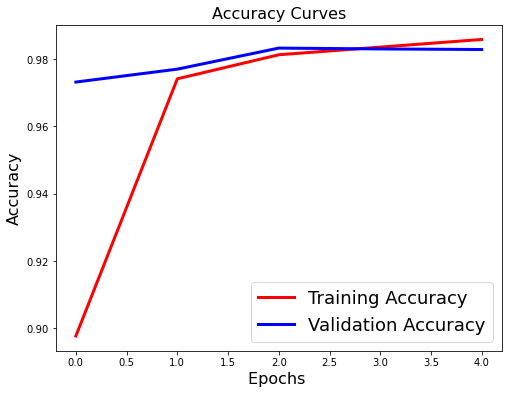

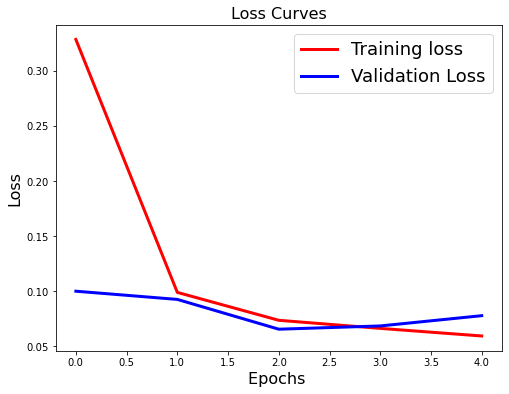

In [10]:
#plot the loss and accuracy curves
def loss_curve(history):
    
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

def accuracy_curve(history):
    
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    
accuracy_curve(history)
loss_curve(history)

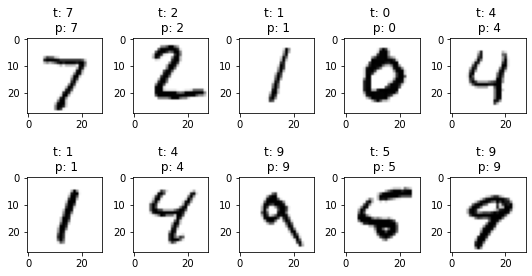

In [11]:
#we should review 
def plot_predictions(x_test, y_true, y_prediction):
    #indice = rd.choice(np[0])   random 10 values
    num_cols = 5
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols,2*num_rows))
    for i in range(len(x_test)):
        ax = axes[i//num_cols, i%num_cols]
        ax.imshow(x_test[i], cmap='gray_r')
        ax.set_title('t: {} \n p: {}'.format(np.argmax(y_true[i]), y_prediction[i]))
    plt.tight_layout()
    plt.show()
    
plot_predictions(X_test[:10], Y_test[0:10], predictions[0:10])

# Generating adversarial attack

In [12]:
tf.version

<module 'tensorflow._api.v2.version' from '/opt/conda/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [13]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

signed = adversarial_pattern(X_test, Y_test)

In [14]:
perturbed_data = X_test + 0.2 * signed #0.2
X_perturbed = perturbed_data.numpy()

In [15]:
adversarial_predictions = model.predict_classes(X_perturbed)
accuracy_score(Y_test, to_categorical(adversarial_predictions))

0.1868

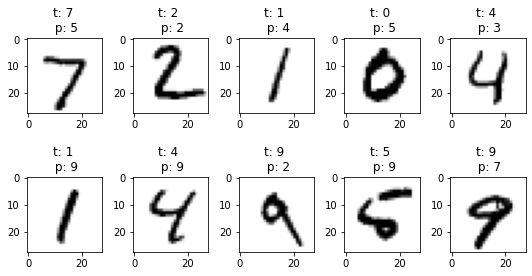

In [16]:
plot_predictions(X_test[:10], Y_test[0:10], adversarial_predictions[0:10])

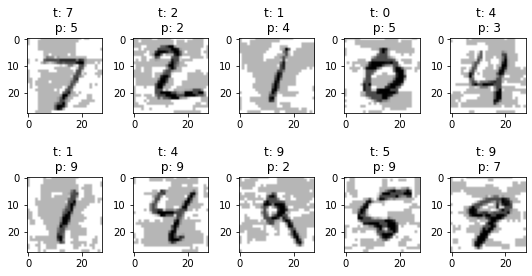

In [17]:
plot_predictions(X_perturbed[:10], Y_test[0:10], adversarial_predictions[0:10])

Apply adversarial attack iteratively

In [18]:
def itrAdvAttacks(itr, epsilon, alfa, image, label):
    adversarial = image
    for i in range(itr):
        n = alfa * adversarial_pattern(adversarial, label)
        adversarial += n
        maxValues = np.maximum((image-epsilon), np.array(adversarial)) 
        adversarial = np.minimum((image+epsilon), maxValues)
        
        itrPrediction = model.predict_classes(adversarial)
        #print(i, np.array(itrPrediction).shape)
        print("iteration ", (i+1) , accuracy_score(Y_test, to_categorical(itrPrediction)))
    
    return adversarial

iterativeAdv = itrAdvAttacks(5, 0.1, 0.05, X_test, Y_test)

iteration  1 0.7836
iteration  2 0.3371
iteration  3 0.2213
iteration  4 0.1442
iteration  5 0.125


In [19]:
itrPred = model.predict_classes(iterativeAdv)

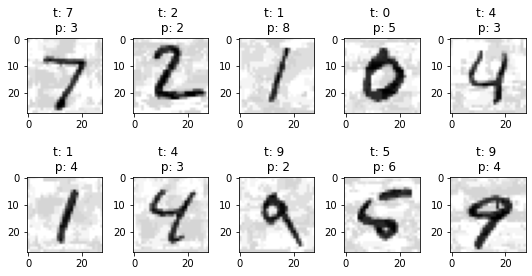

In [20]:
plot_predictions(iterativeAdv[:10], Y_test[0:10], itrPred[0:10])